In [1]:
!pip install simpletransformers

     |████████████████████████████████| 249 kB 29.4 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 1.8 MB 45.3 MB/s 
     |████████████████████████████████| 346 kB 70.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 4.2 MB 52.2 MB/s 
     |████████████████████████████████| 1.2 MB 50.6 MB/s 
     |████████████████████████████████| 10.1 MB 54.6 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 
     |████████████████████████████████| 145 kB 64.7 MB/s 
     |████████████████████████████████| 181 kB 48.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 140 kB 57.5 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
     |████████████████████████████████| 212 kB 14.7 MB/s 
     |████████████████████████████████| 127 kB 50.7 MB/s 
     |█████████████

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from simpletransformers.classification import ClassificationModel, ClassificationArgs

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pd.set_option('max_colwidth', 350)

# Colab
full_df = pd.read_csv('/content/drive/My Drive/dataset/blog_authorship.tsv', sep='\t', usecols=['text', 'gender', 'age', 'length'])

# Local
# full_df = pd.read_csv('../datasets/blog_authorship.tsv', sep='\t', usecols=['text', 'gender', 'age', 'length'])

full_df.sample(10)

,text,gender,age,length
709382,&nbsp; morning sunlight and coffee. &nbsp; brooms and dustpans. &nbsp; laundry soap and pine scented floor cleaner. &nbsp; a watering can and the smell of dirt in the garden. &nbsp; and the quiet. so quiet. &nbsp; no music. no television. just the sounds of outside. birds and dogs and kids on bikes. &nbsp; ...,female,34,64
479974,"Today i tested positive for mono. As well as strange liver enzyme action, which apparently comes along with mono. And although yesterday nothing hurt where it was supposed to, today, everything hurt where it was supposed to. Dammit! The doctor sent me home with more information, instructions for rest and fluids, and a few bags of medications.. ...",female,23,427
410801,is anyone there,male,25,3
496137,"Due to the oncoming Project's Day, I have to use up my entire precious Saturday for Project work! And there goes my weekend! &nbsp; For the whole day I spent 11 solid hours (8am to 12pm, 2pm to 6pm, 8pm tp 11pm) for my Project, named Plant Tissue Culture. &nbsp; Mr Goh went extremely sacarstic today. So my group members and&nbsp;I spent age...",male,14,255
425008,"This is Benjamin Ross Hoffman's blog. I intend to blog about politics (not too much, don't worry), my production of Animal Crackers, and other assorted aspects of my quest to become a God on Earth.",male,17,35
399461,"A long time ago, there was a huge apple tree. A little boy loved to come and play around it everyday. He climbed to the tree top, ate the apples, took a nap under the shadow... He loved the tree and the tree loved to play with him. Time went by... The little boy had grown up and he no longer played around the tree everyday. One day, the boy ca...",male,17,570
494822,&nbsp; Holy crap! The sec 4s didn't hafta go away! Stupid Lim Jee Nee our Head of Pupil Welfare just gave them a lecture! SHEESH.,male,14,25
144673,"Some nice, cleaned up and layed-out pdfs, suitable for handing out to players in most cost conscious groups. Not a bad job with the look, a suitable alternative. urlLink TheOtherGameCompany.com Just remember though that the SRDs do not reprint the experience progression material. So, you will need a PHB for that and perhaps another thing or...",male,36,57
668474,"I am sure that I read something somewhere that said there is a part of the body called 'Grists Tear Duct', and I also read that it is really easy to damage it, especially when performing dumb feats!!! Hmmm.... a list of Toaster Files body parts, could be interesting!!! 1) the 'Gristus' Tear Duct 2) the 'Adams' Elbow Joint 3) Ear Lobus Marcus ...",male,27,81
220735,"urlLink Here's another article about Bush using images of 9-11 victims in his campaign ads, thereby trivializing and exploiting perhaps the greatest tragedy in American history in order to help his chances of re-election. I can't wait till this scumbag is gone from the Oval Office...",male,24,46


In [5]:
df = full_df.sample(frac=.025)
print(f'From {full_df.shape[0]:,} rows to just {df.shape[0]:,}')

From 727,712 rows to just 18,193


In [6]:
df['gender'].value_counts()

male      9345
female    8848
Name: gender, dtype: int64

In [7]:
df['length'].max()

17503

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=97, stratify=df['gender'])
train_df, dev_df = train_test_split(train_df, test_size=0.25, shuffle=True, random_state=97, stratify=train_df['gender'])

train_df.shape, dev_df.shape, test_df.shape

((10915, 4), (3639, 4), (3639, 4))

In [9]:
model_args = ClassificationArgs()

model_args.overwrite_output_dir = True # overwrite existing saved models in the same directory
model_args.evaluate_during_training = True # to perform evaluation while training the model (eval data should be passed to the training method)

model_args.num_train_epochs = 4
model_args.reprocess_input_data = True
model_args.train_batch_size = 8
model_args.learning_rate = 1e-5 
model_args.labels_list = ['female', 'male']
model_args.max_seq_length = 512

model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01 
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True 
model_args.early_stopping_patience = 2

# model_args.evaluate_during_training_steps = 34 
# model_args.evaluate_during_training_silent = False
# model_args.evaluate_each_epoch = False

In [10]:
model = ClassificationModel('bert', 'bert-base-cased',  num_labels=2, args=model_args, use_cuda=True) 

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/10915 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1365 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3639 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1365 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3639 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3639 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1365 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3639 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3639 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1365 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3639 [00:00<?, ?it/s]

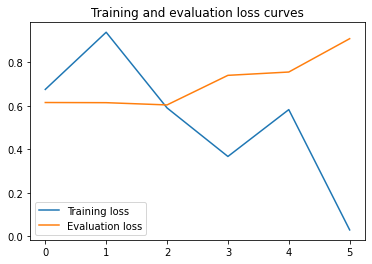

In [11]:
_, history = model.train_model(train_df, eval_df=dev_df)

train_loss = history['train_loss']
eval_loss = history['eval_loss']

plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss curves')
plt.legend()
plt.show()

In [12]:
predicted, probabilities = model.predict(test_df.text.to_list())
test_df['gender_pred'] = predicted

  0%|          | 0/3639 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      female       0.65      0.62      0.63      1770
        male       0.66      0.68      0.67      1869

    accuracy                           0.65      3639
   macro avg       0.65      0.65      0.65      3639
weighted avg       0.65      0.65      0.65      3639



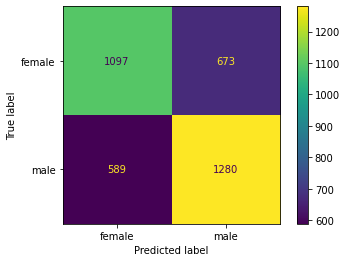

In [14]:
print(classification_report(test_df['gender'], test_df['gender_pred']))

cm = confusion_matrix(test_df['gender'], test_df['gender_pred'], labels=['female', 'male'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['female', 'male'])
disp.plot();